# ORF recognition by CNN
Compare to ORF_CNN_100.
Use 20K seqs/class (instead of 2K).
Run on CoLab (instead of Mac).

In [1]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=1000            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 8   # how many different patterns the model looks for
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [2]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [3]:
from os import listdir
import time # datetime
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [4]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-16 19:16:44 UTC'

In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
print("Train on",len(nc_train),"NC seqs")

Train on 20000 PC seqs
Train on 20000 NC seqs


In [6]:
# Use code from our LearnTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=4,output_dim=4)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,
                  padding="same",input_shape=INPUT_SHAPE))
    # Data shape: [SAMPLES,BASES,FILTERS]
    #dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    # Data shape: [SAMPLES,BASES*FILTERS]
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (1000, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 8)           104       
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8001      
Total params: 8,105
Trainable params: 8,105
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6969 - accuracy: 0.5641 - val_loss: 0.6242 - val_accuracy: 0.6557
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5972 - accuracy: 0.6831 - val_loss: 0.6254 - val_accuracy: 0.6532
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5839 - accuracy: 0.6901 - val_loss: 0.6247 - val_accuracy: 0.6550
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5837 - accuracy: 0.6907 - val_loss: 0.6258 - val_accuracy: 0.6545
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5814 - accuracy: 0.6930 - val_loss: 0.6255 - val_accuracy: 0.6522
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5751 - accuracy: 0.7001 - val_loss: 0.6286 - val_accuracy: 0.6497
Epoch 7/50
1000/1000 [==========

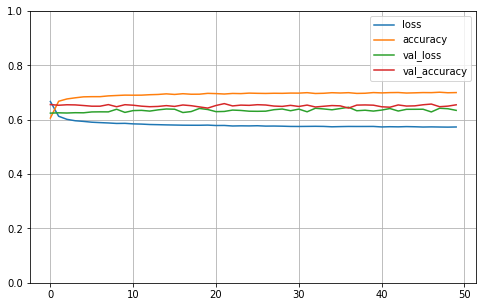

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6900 - accuracy: 0.5730 - val_loss: 0.6365 - val_accuracy: 0.6389
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5992 - accuracy: 0.6803 - val_loss: 0.6445 - val_accuracy: 0.6375
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5895 - accuracy: 0.6823 - val_loss: 0.6370 - val_accuracy: 0.6429
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5817 - accuracy: 0.6919 - val_loss: 0.6382 - val_accuracy: 0.6424
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5794 - accuracy: 0.6951 - val_loss: 0.6396 - val_accuracy: 0.6436
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5767 - accuracy: 0.6982 - val_loss: 0.6422 - val_accuracy: 0.6405
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5757

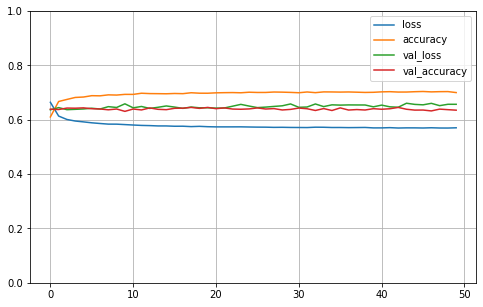

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6887 - accuracy: 0.5771 - val_loss: 0.6369 - val_accuracy: 0.6361
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5962 - accuracy: 0.6825 - val_loss: 0.6402 - val_accuracy: 0.6366
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5856 - accuracy: 0.6863 - val_loss: 0.6403 - val_accuracy: 0.6403
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5807 - accuracy: 0.6943 - val_loss: 0.6387 - val_accuracy: 0.6401
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5770 - accuracy: 0.6956 - val_loss: 0.6582 - val_accuracy: 0.6260
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5775 - accuracy: 0.6972 - val_loss: 0.6465 - val_accuracy: 0.6365
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.57

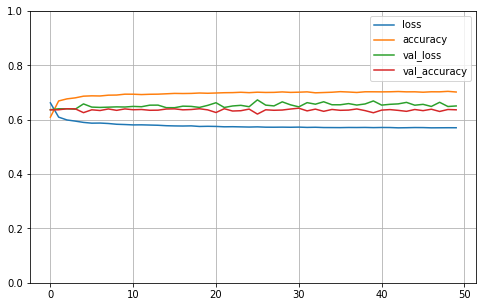

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6871 - accuracy: 0.5802 - val_loss: 0.6326 - val_accuracy: 0.6491
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6015 - accuracy: 0.6754 - val_loss: 0.6350 - val_accuracy: 0.6460
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5886 - accuracy: 0.6855 - val_loss: 0.6344 - val_accuracy: 0.6500
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5815 - accuracy: 0.6928 - val_loss: 0.6348 - val_accuracy: 0.6469
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5798 - accuracy: 0.6923 - val_loss: 0.6346 - val_accuracy: 0.6475
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5734 - accuracy: 0.7022 - val_loss: 0.6373 - val_accuracy: 0.6454
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.58

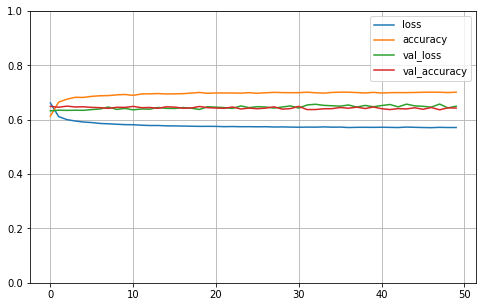

MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.7018 - accuracy: 0.5640 - val_loss: 0.6458 - val_accuracy: 0.6376
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6004 - accuracy: 0.6749 - val_loss: 0.6407 - val_accuracy: 0.6466
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5911 - accuracy: 0.6865 - val_loss: 0.6445 - val_accuracy: 0.6460
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5776 - accuracy: 0.6979 - val_loss: 0.6438 - val_accuracy: 0.6451
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5759 - accuracy: 0.6978 - val_loss: 0.6557 - val_accuracy: 0.6406
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5742 - accuracy: 0.7017 - val_loss: 0.6510 - val_accuracy: 0.6305
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.57

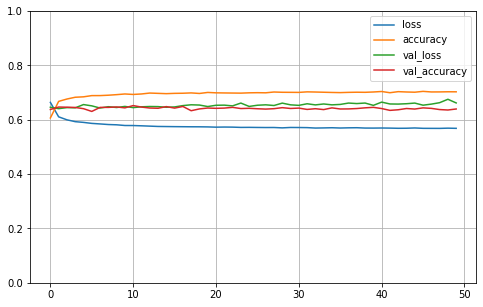

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 63.45%


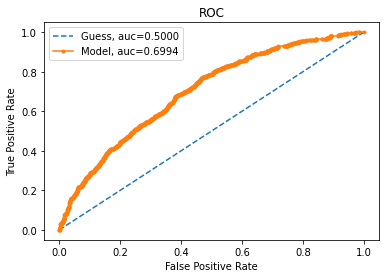

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc))